In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models

In [2]:
log_dir = "logs/fit/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [3]:
df = pd.read_pickle('datasetFER.pkl')

In [4]:
df.head()

,Imagen,Imagen con zoom,Hitos faciales,Etiquetas
0,"[[127, 127, 125, 123, 121, 122, 123, 124, 127,...","[[127, 127, 125, 123, 121, 122, 123, 124, 127,...","[[18, 37], [18, 51], [18, 66], [21, 81], [27, ...",angry
1,"[[248, 248, 246, 245, 243, 246, 249, 253, 254,...","[[248, 248, 246, 245, 243, 246, 249, 253, 254,...","[[-6, 42], [-7, 63], [-5, 84], [-2, 104], [6, ...",angry
2,"[[225, 225, 226, 228, 230, 230, 230, 230, 230,...","[[210, 206, 208, 211, 214, 215, 216, 217, 216,...","[[35, 56], [35, 65], [36, 74], [39, 83], [42, ...",angry
3,"[[118, 118, 86, 52, 18, 13, 15, 16, 16, 14, 13...","[[65, 78, 90, 102, 110, 117, 125, 129, 133, 13...","[[35, 86], [38, 98], [44, 109], [53, 118], [62...",angry
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[37, 34], [34, 49], [33, 64], [35, 80], [39, ...",angry


In [5]:
import numpy as np
from PIL import Image

# Función para redimensionar una imagen
def redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto):
    img = Image.fromarray(imagen)
    img = img.resize((nuevo_ancho, nuevo_alto))
    return np.array(img)

# Definir el tamaño al que quieres redimensionar todas las imágenes
nuevo_ancho = 48
nuevo_alto = 48

# Redimensionar todas las imágenes a la misma forma y convertirlas en arreglos numpy
X = np.array([redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto) for imagen in df['Imagen con zoom']])


In [6]:
X = X / 255.0

In [7]:
etiquetas = df['Etiquetas'].astype('category').cat.codes

In [8]:
print(etiquetas)

0        0
1        0
2        0
3        0
4        0
        ..
25680    6
25681    6
25682    6
25683    6
25684    6
Length: 25685, dtype: int8


In [9]:
print(etiquetas.unique())

[0 1 2 3 4 5 6]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.3,stratify=etiquetas, random_state=42)

In [11]:
# Definir el modelo CNN
model = models.Sequential([
    layers.Conv2D(256, (5, 5), activation='relu', input_shape=(nuevo_ancho, nuevo_alto, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(etiquetas), activation='softmax')
])

In [12]:
#compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model.fit(X_train, y_train, epochs=20, batch_size=16, callbacks=[tensorboard_callback])

Epoch 1/20
1124/1124 [==============================] - 27s 21ms/step - loss: 1.9140 - accuracy: 0.2612
Epoch 2/20
1124/1124 [==============================] - 25s 22ms/step - loss: 1.7831 - accuracy: 0.2851
Epoch 3/20
1124/1124 [==============================] - 26s 23ms/step - loss: 1.5213 - accuracy: 0.4224
Epoch 4/20
1124/1124 [==============================] - 26s 23ms/step - loss: 1.3880 - accuracy: 0.4773
Epoch 5/20
1124/1124 [==============================] - 25s 22ms/step - loss: 1.3046 - accuracy: 0.5090
Epoch 6/20
1124/1124 [==============================] - 25s 22ms/step - loss: 1.2425 - accuracy: 0.5348
Epoch 7/20
1124/1124 [==============================] - 24s 21ms/step - loss: 1.1945 - accuracy: 0.5492
Epoch 8/20
1124/1124 [==============================] - 24s 22ms/step - loss: 1.1502 - accuracy: 0.5645
Epoch 9/20
1124/1124 [==============================] - 27s 24ms/step - loss: 1.1085 - accuracy: 0.5809
Epoch 10/20
1124/1124 [==============================] - 25s 23m

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calcular la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

print("Matriz de confusión:")
print(confusion_mat)

241/241 [==============================] - 5s 17ms/step - loss: 1.4943 - accuracy: 0.5593
Precisión del modelo en el conjunto de prueba: 0.559304416179657
241/241 [==============================] - 3s 11ms/step
Matriz de confusión:
[[ 425    7  163   85  168  185   34]
 [  33   27   24    8   11   23    3]
 [ 119    3  347   84  167  144  115]
 [  35    4   77 1762  152   68   41]
 [  98    7  108  177  771  218   45]
 [ 123    8  121  106  306  360   34]
 [  29    0  107   83   59   14  618]]


241/241 [==============================] - 3s 13ms/step


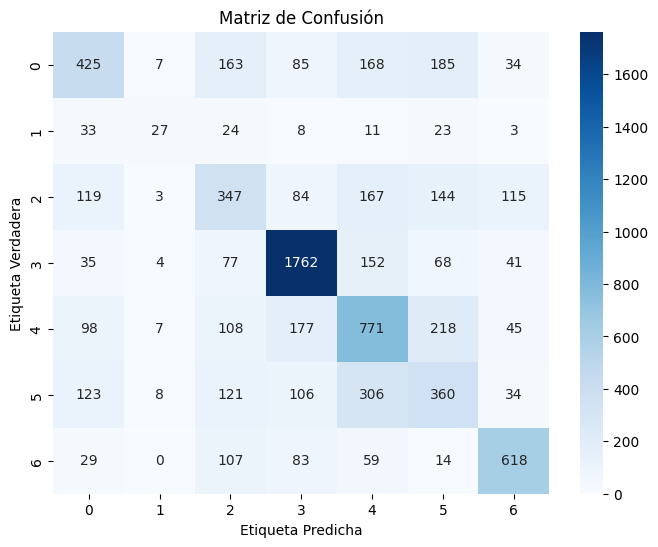

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Plotear la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


In [17]:
model.save('modeloFERCNN.h5')